# K Nearest Neighbors

## Reading the data

In [242]:
using DelimitedFiles
using Statistics
using LinearAlgebra
using Plots
using Distances
using JSON

In [2]:
function data_read(str::String)
    data = readdlm(str, ',', Float64, '\n');
    return data
end;

In [3]:
data = data_read("../data/data2.txt");

In [4]:
X = data[:,1:end-1];
y = data[:,end];

## Calculating the nearest neighbors

To calculate the nearest neighbors we can use the euclidean distance. Using this, we can calculate the distance between two vectors using the formula

$$
d(x,y) = \sqrt{\sum_{i=1}^n (x_i-y_i)^2}
$$

Using vectors we can optimize this by doing

$$
d(x,y) = (x-y)^T \cdot (x-y)
$$

We can do this using the code:

In [5]:
function euclidean_distance(x,y)
    return sqrt(transpose(x-y) * (x-y))
end;

In [6]:
euclidean_distance([1,2,3,4], [3,2,3,5])

2.23606797749979

But for efficiency purposes we will be using the library Distances, using Euclidean distance as our metric of choice.

In [7]:
evaluate(Euclidean(), [1,2,3,4], [3,2,3,5])

2.23606797749979

## K Nearest Neighbors Regressor

To implement this algorithm we have to measure the distance to all known data, take the nearest data to the point we want to predict and then taking the mean of this points as the predicted value. Also, we can implemetn a weighted regressor where instead of just taking the mean of the points we take a weighted mean.

In [16]:
function k_neighbors_regressor(X,y, x_hat, k)
    dist = colwise(Euclidean(), transpose(X),x_hat)
    k_nearest = y[sortperm(dist)[1:k]]
    return mean(k_nearest) 
end;

In [17]:
function weighted_k_neighbors_regressor(X,y, x_hat, k)
    dist = colwise(SqEuclidean(), transpose(X),x_hat)
    k_nearest = y[sortperm(dist)[1:k]]
    weights = reverse(dist[sortperm(dist)[1:k]]/sum(dist[sortperm(dist)[1:k]]))
    return transpose(k_nearest) * weights
end;

In [18]:
k_neighbors_regressor(X, y, [1,2], 10)

233980.0

In [19]:
weighted_k_neighbors_regressor(X, y, [1,2], 10)

230110.58555316663

We can calculate the root mean square error (RMSE) by

$$
E(x,y) = \sqrt{\frac{d(x,y)^2}{n}}
$$

Where $d(x,y)^2$ is the squared euclidean distance, because we know that

$$
d(x,y) = \sqrt{\sum_{i=1}^n (x_i-y_i)^2}
$$

So

$$
d(x,y)^2 = \sum_{i=1}^n (x_i-y_i)^2
$$

## Plotting the error

We can plot the error using the data we already have. Using cross validation, we can se what the predicted value would be for the data in $X$ and compare it with the real value in $y$.

We can see that for the k neighbors regressor the best value we can use with this data should be 4.

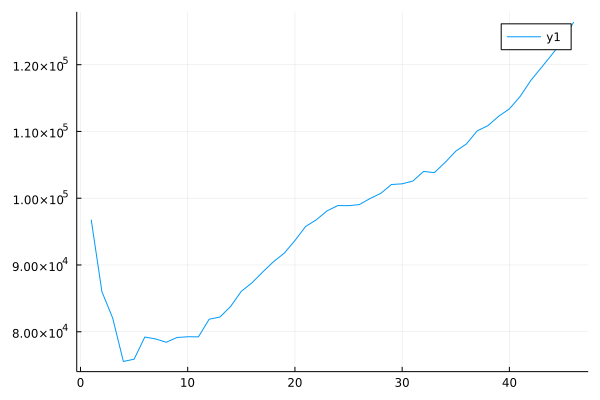

In [30]:
plot(
    [
        sqrt(evaluate(
            SqEuclidean(),
            [
                k_neighbors_regressor(
                    X[1:end .!= i, :],
                    y[1:end .!= i],
                    X[i,:],
                    k
                    )
                for i=1:size(X)[1]],
            y
        )/size(X)[1])
        for k=1:size(X)[1]-1]
)

In [35]:
argmin([sqrt(evaluate(SqEuclidean(),[k_neighbors_regressor(X[1:end .!= i, :],y[1:end .!= i],X[i,:],k) for i=1:size(X)[1]],y)/size(X)[1]) for k=1:size(X)[1]-1])

4

For the weighted version, we can see that using a bit more of neighbors is better. Because farthest neighbors are given less weight, but can still improve the error slightly.

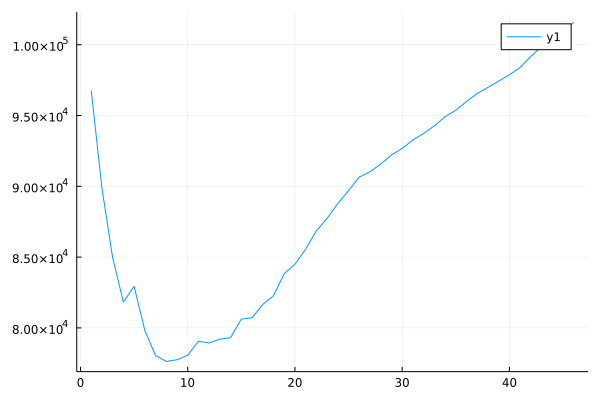

In [36]:
plot(
    [
        sqrt(evaluate(
            SqEuclidean(),
            [
                weighted_k_neighbors_regressor(
                    X[1:end .!= i, :],
                    y[1:end .!= i],
                    X[i,:],
                    k
                    )
                for i=1:size(X)[1]],
            y
        )/size(X)[1])
        for k=1:size(X)[1]-1]
)

In [37]:
argmin([sqrt(evaluate(SqEuclidean(),[weighted_k_neighbors_regressor(X[1:end .!= i, :],y[1:end .!= i],X[i,:],k) for i=1:size(X)[1]],y)/size(X)[1]) for k=1:size(X)[1]-1])

8

# K Nearest Neighbors Classifier

For this example we will use the famous iris dataset.

In [111]:
using RDatasets: dataset
using CategoricalArrays
using StatsBase

iris = dataset("datasets", "iris");

In [74]:
X = Matrix(iris[:,1:end-1]);
y = iris[:,end];

## Classifier Algorithm

For classification, it is done the same thing as regression, but with the difference that the probability that a new value belongs to a certain class is measured by:

$$
P(Y=j|X=x_0) = \frac{1}{k} \sum_{x_i\in N_k(x_0)} I(y_i = j)
$$

When there are multiple classes and we want to measure which class is it we can just take the mode of $N_k(x_0)$.

In [234]:
function k_neighbors_classifier(X,y, x_hat, k)
    dist = colwise(Euclidean(), transpose(X),x_hat)
    k_nearest = y[sortperm(dist)[1:k]]
    d = countmap(k_nearest)
    return Dict(i=>j/k for (i,j) in d)
end;

In [246]:
k_neighbors_classifier(X,y,[1,2,3,4], 12)

Dict{CategoricalValue{String, UInt8}, Float64} with 3 entries:
  "virginica"  => 0.166667
  "versicolor" => 0.666667
  "setosa"     => 0.166667

In [247]:
function k_neighbors_classifier(X,y, x_hat, k)
    dist = colwise(Euclidean(), transpose(X),x_hat)
    k_nearest = y[sortperm(dist)[1:k]]
    d = countmap(k_nearest)
    return collect(keys(d))[argmax(collect(values(d)))]
end;

In [248]:
k_neighbors_classifier(X,y,[1,2,3,4], 12)

CategoricalValue{String, UInt8} "versicolor"

## Accurracy

### Training error

We can see the accurracy using the training data using different $k$ values. We can clonclude that it is not good to use higher $k$ values, with the optimum being between 4 and 20 in this case.

In [226]:
training_accurracy = [count([k_neighbors_classifier(X,y,X[i,:],k) for i=1:size(X)[1]].==y)/size(X)[1] for k=2:size(X)[1]-1];

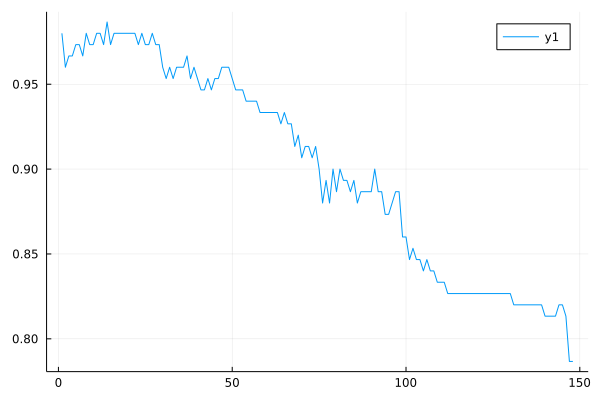

In [227]:
plot(training_accurracy)

Here we can see the error percentage using different $k$ values and using only training values.

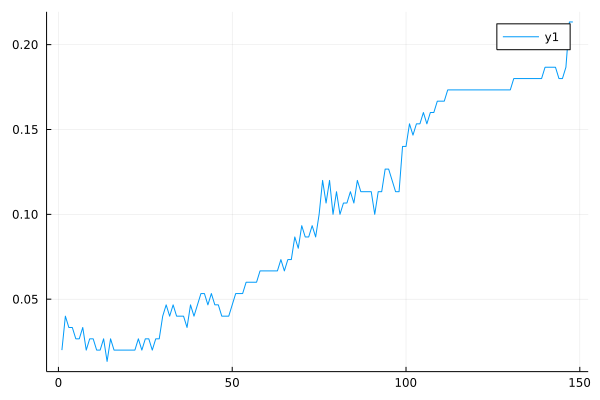

In [228]:
plot(abs.(training_accurracy.-1))

### Test error

Here we can see different test accurracy using different $k$ values. The same as in the training error we can see that it is not good to have a higher test values because accurracy can drop dramatically.

In [225]:
test_accurracy = [count([k_neighbors_classifier(X[1:end .!= i, :],y[1:end .!= i],X[i,:],k) for i=1:size(X)[1]].==y)/size(X)[1] for k=1:size(X)[1]-1];

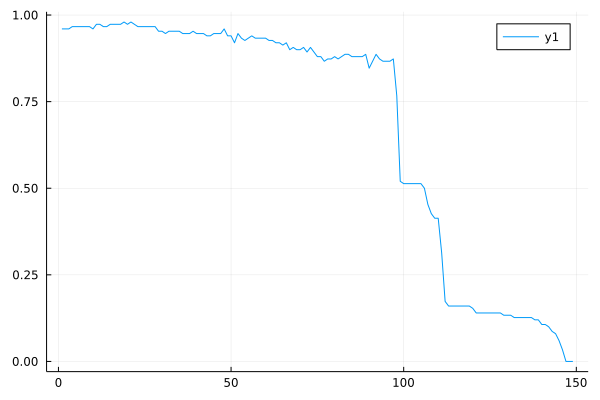

In [229]:
plot(test_accurracy)

We can also see the error. divided between different $k$ values. This plot was used only with values $k<50$ so that it can be better interpreted.

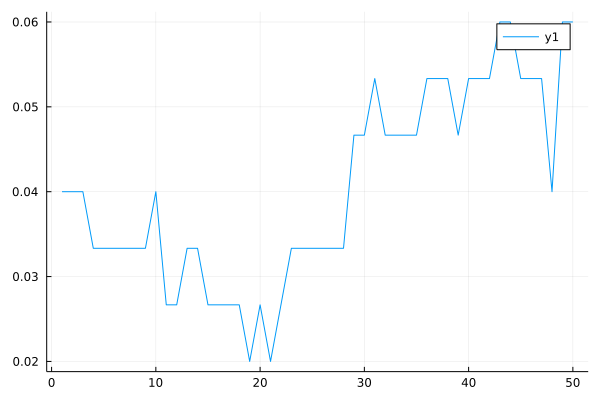

In [231]:
plot(abs.(test_accurracy[1:50].-1))

In [232]:
argmax(test_accurracy)

19

In this case, the best accurracy is accomplished when $k=19$.